<h1> <i> RFM & K-Means Analysis

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_excel("Walmart Sales.xlsx")

In [36]:
df

,CustomerID,Purchase_Date,Quantity,UnitPrice,Gender,City,Age,MonthlyIncome,Product_Name
0,C53563,2021-03-24,3,643,Male,Denver,33,4980,Washing machine
1,C39154,2021-03-23,1,569,Female,San Diego,27,7141,Mobile phone
2,C39154,2021-03-30,2,69,Female,San Diego,27,7141,Pet food
3,C39154,2021-09-19,10,105,Female,San Diego,27,7141,Vitamin
4,C39154,2021-02-08,1,521,Female,San Diego,27,7141,Mobile phone
...,...,...,...,...,...,...,...,...,...
124274,C46189,2021-06-28,10,3,Female,Boston,26,6113,Clothing
124275,C46189,2021-06-26,3,483,Female,Boston,26,6113,Mobile phone
124276,C46189,2021-03-13,4,39,Female,Boston,26,6113,Plants
124277,C52591,2021-03-14,6,36,Female,San Diego,67,2702,Pet food


In [37]:
df.describe() # Getting Statistical information

,Quantity,UnitPrice,Age,MonthlyIncome
count,124279.000000,124279.000000,124279.000000,124279.000000
mean,4.505958,196.565268,51.284835,5720.114637
std,2.926061,216.382188,18.885571,1853.693784
min,1.000000,3.000000,18.000000,2501.000000
25%,2.000000,47.000000,36.000000,4086.000000
50%,4.000000,91.000000,51.000000,5847.000000
75%,7.000000,391.000000,67.000000,7263.000000
max,10.000000,699.000000,83.000000,8997.000000


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124279 entries, 0 to 124278
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CustomerID     124279 non-null  object        
 1   Purchase_Date  124279 non-null  datetime64[ns]
 2   Quantity       124279 non-null  int64         
 3   UnitPrice      124279 non-null  int64         
 4   Gender         124279 non-null  object        
 5   City           124279 non-null  object        
 6   Age            124279 non-null  int64         
 7   MonthlyIncome  124279 non-null  int64         
 8   Product_Name   124279 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 8.5+ MB


In [39]:
print("Count of Duplicates:", df.duplicated().sum())
print("Count of NA values:", df.isna().sum().sum())
print("Single valued columns:", df.columns[df.nunique()==1])

Count of Duplicates: 9
Count of NA values: 0
Single valued columns: Index([], dtype='object')


In [40]:
df.drop_duplicates(inplace = True)

In [41]:
df['Quantity'].value_counts()

3     20780
2     20739
1     20487
6      9068
8      8891
10     8890
5      8873
4      8863
7      8859
9      8820
Name: Quantity, dtype: int64

# Recency

In [42]:
df['Purchase_Date'] = pd.DatetimeIndex(df['Purchase_Date']).date

In [43]:
recency_df = df.groupby(by='CustomerID', as_index=False)['Purchase_Date'].max()
recency_df.columns = ['CustomerID','Last_purshace_date']
max_date=recency_df.Last_purshace_date.max()
recency_df['Recency'] = recency_df['Last_purshace_date'].apply(lambda x: (max_date - x).days)
recency_df.head(7)

,CustomerID,Last_purshace_date,Recency
0,C37051,2021-07-06,86
1,C37054,2021-09-28,2
2,C37057,2021-07-31,61
3,C37060,2021-08-31,30
4,C37063,2021-09-24,6
5,C37069,2021-09-21,9
6,C37072,2021-03-11,203


# Frequency

In [44]:
copy_data = df
copy_data.drop_duplicates(subset=['Product_Name', 'CustomerID'], keep="first", inplace=True)

In [45]:
frequency_df = copy_data.groupby(by=['CustomerID'], as_index=False)['Product_Name'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,C37051,2
1,C37054,7
2,C37057,4
3,C37060,7
4,C37063,2


# Monetary

In [46]:
df.columns

Index(['CustomerID', 'Purchase_Date', 'Quantity', 'UnitPrice', 'Gender',
       'City', 'Age', 'MonthlyIncome', 'Product_Name'],
      dtype='object')

In [47]:
df['Cost'] = df['Quantity'] * df['UnitPrice']
monetary_df = df.groupby(by='CustomerID',as_index=False).agg({'Cost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,C37051,307
1,C37054,3024
2,C37057,3175
3,C37060,2753
4,C37063,1678


In [48]:
comb1 = recency_df.merge(frequency_df,on='CustomerID')
final_RFM = comb1.merge(monetary_df,on='CustomerID')
final_RFM.head(7)

,CustomerID,Last_purshace_date,Recency,Frequency,Monetary
0,C37051,2021-07-06,86,2,307
1,C37054,2021-09-28,2,7,3024
2,C37057,2021-07-31,61,4,3175
3,C37060,2021-08-31,30,7,2753
4,C37063,2021-09-24,6,2,1678
5,C37069,2021-09-21,9,7,3890
6,C37072,2021-03-11,203,1,504


# Ranking RFM  scores

In [49]:
final_RFM['Recency_rank'] = final_RFM['Recency'].rank( ascending=False) 
final_RFM['Frequency_rank'] = final_RFM['Frequency'].rank(ascending=True)
final_RFM['Monetary_rank'] = final_RFM['Monetary'].rank(ascending=True)
final_RFM.head(7)

,CustomerID,Last_purshace_date,Recency,Frequency,Monetary,Recency_rank,Frequency_rank,Monetary_rank
0,C37051,2021-07-06,86,2,307,391.5,342.0,94.5
1,C37054,2021-09-28,2,7,3024,3437.5,3298.0,1995.5
2,C37057,2021-07-31,61,4,3175,607.5,1005.5,2207.5
3,C37060,2021-08-31,30,7,2753,1160.5,3298.0,1691.0
4,C37063,2021-09-24,6,2,1678,2698.5,342.0,791.5
5,C37069,2021-09-21,9,7,3890,2312.5,3298.0,3082.5
6,C37072,2021-03-11,203,1,504,59.5,107.0,181.0


# Normalization of RFM ranked scores

In [50]:
final_RFM['Recency_rank_norm']=(final_RFM['Recency_rank']/final_RFM['Recency_rank'].max())*100
final_RFM['Frequency_rank_norm']=(final_RFM['Frequency_rank']/final_RFM['Frequency_rank'].max())*100
final_RFM['Monetary_rank_norm']=(final_RFM['Monetary_rank']/final_RFM['Monetary_rank'].max())*100
final_RFM.head(7)

,CustomerID,Last_purshace_date,Recency,Frequency,Monetary,Recency_rank,Frequency_rank,Monetary_rank,Recency_rank_norm,Frequency_rank_norm,Monetary_rank_norm
0,C37051,2021-07-06,86,2,307,391.5,342.0,94.5,9.612080,10.369921,2.210009
1,C37054,2021-09-28,2,7,3024,3437.5,3298.0,1995.5,84.397250,100.000000,46.667446
2,C37057,2021-07-31,61,4,3175,607.5,1005.5,2207.5,14.915296,30.488175,51.625351
3,C37060,2021-08-31,30,7,2753,1160.5,3298.0,1691.0,28.492512,100.000000,39.546305
4,C37063,2021-09-24,6,2,1678,2698.5,342.0,791.5,66.253376,10.369921,18.510290
5,C37069,2021-09-21,9,7,3890,2312.5,3298.0,3082.5,56.776332,100.000000,72.088400
6,C37072,2021-03-11,203,1,504,59.5,107.0,181.0,1.460840,3.244391,4.232928


In [51]:
# Calculate RFM score
final_RFM['RFM_Score']=0.2*final_RFM['Recency_rank_norm']+0.2*final_RFM['Frequency_rank_norm']+0.6*final_RFM['Monetary_rank_norm']
final_RFM=final_RFM.round(0)
final_RFM.head()

,CustomerID,Last_purshace_date,Recency,Frequency,Monetary,Recency_rank,Frequency_rank,Monetary_rank,Recency_rank_norm,Frequency_rank_norm,Monetary_rank_norm,RFM_Score
0,C37051,2021-07-06,86,2,307,392.0,342.0,94.0,10.0,10.0,2.0,5.0
1,C37054,2021-09-28,2,7,3024,3438.0,3298.0,1996.0,84.0,100.0,47.0,65.0
2,C37057,2021-07-31,61,4,3175,608.0,1006.0,2208.0,15.0,30.0,52.0,40.0
3,C37060,2021-08-31,30,7,2753,1160.0,3298.0,1691.0,28.0,100.0,40.0,49.0
4,C37063,2021-09-24,6,2,1678,2698.0,342.0,792.0,66.0,10.0,19.0,26.0


- RFM score < 25 then ‘Leaving customers’
- RFM score >= 25 and< 50 then ‘Risky customers’
- RFM score >= 50 and< 75 then ‘Potential Loyalists’
- RFM score >= 75 then ‘Champions’

In [52]:
final_RFM["Customer_segment"]=np.where((final_RFM['RFM_Score'] >= 25) & (final_RFM['RFM_Score'] <50),"Risky Customers",
                                    np.where(final_RFM['RFM_Score'] >= 75 ,"Champions",np.where(final_RFM['RFM_Score'] < 25,"Leaving","Potential Loyalists"))) 
final_RFM.head()

,CustomerID,Last_purshace_date,Recency,Frequency,Monetary,Recency_rank,Frequency_rank,Monetary_rank,Recency_rank_norm,Frequency_rank_norm,Monetary_rank_norm,RFM_Score,Customer_segment
0,C37051,2021-07-06,86,2,307,392.0,342.0,94.0,10.0,10.0,2.0,5.0,Leaving
1,C37054,2021-09-28,2,7,3024,3438.0,3298.0,1996.0,84.0,100.0,47.0,65.0,Potential Loyalists
2,C37057,2021-07-31,61,4,3175,608.0,1006.0,2208.0,15.0,30.0,52.0,40.0,Risky Customers
3,C37060,2021-08-31,30,7,2753,1160.0,3298.0,1691.0,28.0,100.0,40.0,49.0,Risky Customers
4,C37063,2021-09-24,6,2,1678,2698.0,342.0,792.0,66.0,10.0,19.0,26.0,Risky Customers


In [53]:
final_RFM[final_RFM['RFM_Score'] == 75].Customer_segment

5       Champions
39      Champions
48      Champions
70      Champions
105     Champions
          ...    
3996    Champions
4191    Champions
4230    Champions
4241    Champions
4265    Champions
Name: Customer_segment, Length: 76, dtype: object

In [54]:
final_RFM['RFM_Score'].min()

1.0

In [55]:
df.columns

Index(['CustomerID', 'Purchase_Date', 'Quantity', 'UnitPrice', 'Gender',
       'City', 'Age', 'MonthlyIncome', 'Product_Name', 'Cost'],
      dtype='object')

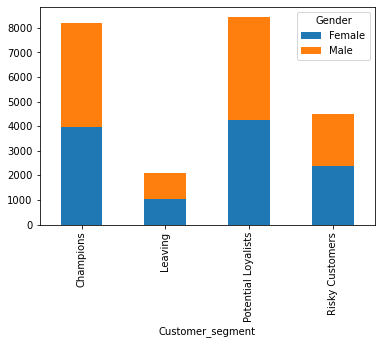

In [56]:
data_rfm_merged = df.merge(final_RFM, on='CustomerID')
data_rfm_merged.groupby('Customer_segment')[['CustomerID']].count()
pd.crosstab(data_rfm_merged['Customer_segment'], data_rfm_merged['Gender']).plot(kind='bar', stacked=True);

In [57]:
pd.crosstab(data_rfm_merged['Customer_segment'], data_rfm_merged['Gender'])

Gender,Female,Male
Customer_segment,,
Champions,3978,4232
Leaving,1052,1029
Potential Loyalists,4244,4182
Risky Customers,2363,2141


Most of the customers are Potential Loyalists and Champions, which is a good indicator. Moreover, the ratio of female and male on each segment is almost equal. However, the company has a lot of risky customers who need extra attention. Compared to loyal and champion customer, the number of leaving clients are low, but it will be recommended for the company to find causes that make clients to leave.

# K-Means clustering analysis

In [58]:
data_rfm_merged.columns

Index(['CustomerID', 'Purchase_Date', 'Quantity', 'UnitPrice', 'Gender',
       'City', 'Age', 'MonthlyIncome', 'Product_Name', 'Cost',
       'Last_purshace_date', 'Recency', 'Frequency', 'Monetary',
       'Recency_rank', 'Frequency_rank', 'Monetary_rank', 'Recency_rank_norm',
       'Frequency_rank_norm', 'Monetary_rank_norm', 'RFM_Score',
       'Customer_segment'],
      dtype='object')

In [59]:
data_k_means = data_rfm_merged[['Recency_rank_norm','Frequency_rank_norm','Monetary_rank_norm','Age','MonthlyIncome']]

In [60]:
model_kmeans = KMeans(n_clusters=2, init='k-means++',random_state=42)
y_means = model_kmeans.fit_predict(data_k_means)
data_rfm_merged["cluster"] = y_means
data_rfm_merged["cluster"].value_counts()

1    11977
0    11244
Name: cluster, dtype: int64

# Using Elbow and Silhouette_score to find the optimal number of clusters

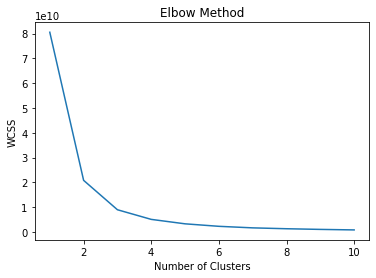

In [61]:
wcss= [] #the sum of squared distance between each point and the centroid in a cluster
for i in range(1,11):
    k_means = KMeans(n_clusters=i, init="k-means++")
    k_means.fit(data_k_means)
    wcss.append(k_means.inertia_)

plt.plot(range(1,11),wcss)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

## From the above we can conclude that the optimal number of clusers is k=2

In [62]:
# Since cluster number isn't changed, the output will be the same as above. 
# However, for convinence, I'll show the same codes here as well.

model_kmeans_3 = KMeans(n_clusters=2, init='k-means++',random_state=42)
y_means = model_kmeans_3.fit_predict(data_k_means)
data_rfm_merged["cluster"] = y_means
data_rfm_merged['cluster'].value_counts()

1    11977
0    11244
Name: cluster, dtype: int64

In [63]:
silhouette_score(data_k_means,y_means)

0.6165042052735574

In [64]:
from itertools import combinations
from scipy.spatial.distance import euclidean

def dunn_index(X, labels):
    """
    Calculate the Dunn Index for a set of clusters.

    Parameters:
        X (numpy.ndarray): Data points in the form of a 2D array (n_samples, n_features).
        labels (numpy.ndarray): Cluster assignments for each data point.

    Returns:
        float: Dunn Index value.
    """
    num_clusters = len(np.unique(labels))
    cluster_centers = []
    cluster_diameters = np.zeros(num_clusters)

    for cluster_id in range(num_clusters):
        cluster_points = X[labels == cluster_id]
        cluster_centers.append(np.mean(cluster_points, axis=0))
        max_diameter = 0

        # Calculate the maximum pairwise distance within each cluster
        for point1, point2 in combinations(cluster_points, 2):
            distance = euclidean(point1, point2)
            if distance > max_diameter:
                max_diameter = distance

        cluster_diameters[cluster_id] = max_diameter

    min_intercluster_distances = np.full((num_clusters, num_clusters), np.inf)

    # Calculate the minimum pairwise distance between cluster centers
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            distance = euclidean(cluster_centers[i], cluster_centers[j])
            min_intercluster_distances[i, j] = distance
            min_intercluster_distances[j, i] = distance

    min_intercluster_distance = np.min(min_intercluster_distances)

    return min_intercluster_distance / np.max(cluster_diameters)


In [65]:
X= data_rfm_merged[['Recency_rank_norm','Frequency_rank_norm','Monetary_rank_norm','Age','MonthlyIncome']].values

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X)

# Calculate the Dunn Index
dunn_value = dunn_index(X, labels)
print(f"Dunn Index: {dunn_value}")

Dunn Index: 0.9889115806442851


In [66]:
# Group the data by 'Cluster' and calculate the average cost for each group
average_monthlysalary_by_cluster = data_rfm_merged.groupby('cluster')['MonthlyIncome'].mean().reset_index()
print(average_monthlysalary_by_cluster)

   cluster  MonthlyIncome
0        0    7389.382337
1        1    4181.456291


Number of customer in the first cluster is 11977 and 11244 in the second cluster. These numbers are close to each other, which means that people are devided into groups equally. One of the characteristics on each group is their monthly income. For the first cluster, average monthly income is 7389.382337, and 4181.456291 for the second cluster.